### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v10.4/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'LatA_5uM', 'fzo1KO', 'CK666')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
# stats_name = "yeast_v10.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v10.4\train\02_mfb1KO
working on: datasets\yeast_v10.4\val\02_mfb1KO
working on: datasets\yeast_v10.4\train\02_mmr1KO
working on: datasets\yeast_v10.4\val\02_mmr1KO
working on: datasets\yeast_v10.4\train\02_mmr1KO-mfb1KO
working on: datasets\yeast_v10.4\val\02_mmr1KO-mfb1KO
working on: datasets\yeast_v10.4\train\02_WT
working on: datasets\yeast_v10.4\val\02_WT
working on: datasets\yeast_v10.4\train\03_dnm1KO
working on: datasets\yeast_v10.4\val\03_dnm1KO
working on: datasets\yeast_v10.4\train\03_fzo1KO
working on: datasets\yeast_v10.4\val\03_fzo1KO
working on: datasets\yeast_v10.4\train\03_LatA-5uM
working on: datasets\yeast_v10.4\val\03_LatA-5uM
working on: datasets\yeast_v10.4\train\03_WT
working on: datasets\yeast_v10.4\val\03_WT
working on: datasets\yeast_v10.4\train\04_WT
working on: datasets\yeast_v10.4\val\04_WT
working on: datasets\yeast_v10.4\test\01_mfb1KO
working on: datasets\yeast_v10.4\test\01_mmm1KO
working on: datasets\yeast_v10.4\test\01_mmr1K

In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

02_mfb1KO: 	 	 	 (array([0.00794, 0.00484]), array([0.00075, 0.00163]))
02_mmr1KO: 	 	 	 (array([0.00799, 0.00503]), array([0.0008 , 0.00186]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.00791, 0.00489]), array([0.00073, 0.00162]))
02_WT: 	 	 	 (array([0.00796, 0.00478]), array([0.00075, 0.00149]))
03_dnm1KO: 	 	 	 (array([0.02515, 0.00477]), array([0.0025 , 0.00192]))
03_fzo1KO: 	 	 	 (array([0.02517, 0.0047 ]), array([0.00202, 0.00202]))
03_LatA-5uM: 	 	 	 (array([0.0253, 0.0049]), array([0.0024, 0.0017]))
03_WT: 	 	 	 (array([0.02536, 0.00459]), array([0.00255, 0.00147]))
04_WT: 	 	 	 (array([0.02535, 0.00493]), array([0.00215, 0.00156]))


In [7]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.0211 , 0.00454]), array([0.00151, 0.00165]))
01_mmm1KO: 	 	 	 (array([0.02102, 0.00424]), array([0.0015 , 0.00181]))
01_mmr1KO: 	 	 	 (array([0.02115, 0.00486]), array([0.00158, 0.00193]))
01_num1KO: 	 	 	 (array([0.02099, 0.00499]), array([0.00156, 0.00208]))
01_WT: 	 	 	 (array([0.0211 , 0.00449]), array([0.00149, 0.00129]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.00792, 0.00489]), array([0.00072, 0.00163]))
03_axl1KO: 	 	 	 (array([0.02548, 0.00475]), array([0.00221, 0.00144]))
03_bud1KO: 	 	 	 (array([0.02544, 0.00459]), array([0.00223, 0.00142]))
03_CK666: 	 	 	 (array([0.02536, 0.00503]), array([0.00261, 0.00168]))
03_DTT: 	 	 	 (array([0.02586, 0.00496]), array([0.00224, 0.00167]))
03_Eth: 	 	 	 (array([0.02533, 0.00469]), array([0.00226, 0.00134]))
03_H2O2: 	 	 	 (array([0.02574, 0.00364]), array([0.00221, 0.00018]))
03_LatA-05uM: 	 	 	 (array([0.02535, 0.00498]), array([0.00252, 0.00168]))


## Defining datasets:

In [8]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [9]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs,
                                                                             test_name='test', test_with_labels=True, balance=True)
    
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
#     print(main_stats_X)
#     print(test_stats_X)
    
    print('\n class to index mapping:\n',lbl2index)
    print('\n class to index mapping:\n',lbl2index_test)
    return create(tfms)

In [10]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO'], '02_mmr1KO-mfb1KO': [3, 3, 'mmr1KO-mfb1KO'], '03_LatA-5uM': [4, 4, 'LatA-5uM'], '03_WT': [5, 0, 'WT'], '03_dnm1KO': [6, 5, 'dnm1KO'], '03_fzo1KO': [7, 6, 'fzo1KO'], '04_WT': [8, 0, 'WT']}

 class to index mapping:
 {'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO'], '02_mmr1KO-mfb1KO': [5, 5, 'mmr1KO-mfb1KO'], '03_CK666': [6, 6, 'CK666'], '03_DTT': [7, 7, 'DTT'], '03_Eth': [8, 8, 'Eth'], '03_H2O2': [9, 9, 'H2O2'], '03_LatA-05uM': [10, 10, 'LatA-05uM'], '03_axl1KO': [11, 11, 'axl1KO'], '03_bud1KO': [12, 12, 'bud1KO']}


In [11]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

315
2594
3380


### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# specify which image-index
idx = 6

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

# Training setup

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

Defining network architecture. 

In [12]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [13]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [14]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [15]:
wd=1e-5 # weight-decay/L2 regularization 

In [16]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 7), data)

In [ ]:
learn.summary()

In [17]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 20/41 [00:10<00:11,  1.83it/s, loss=33.5]

KeyboardInterrupt: 

In [ ]:
data.trn_dl.sampler#__dict__.keys()

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

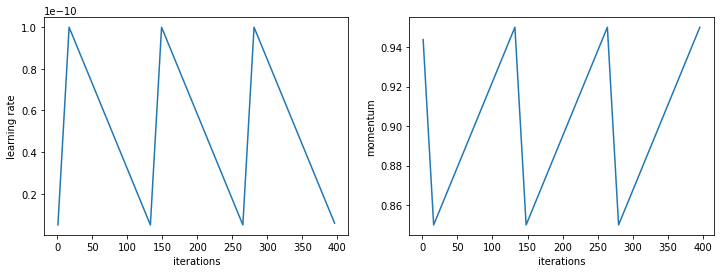

In [33]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [ ]:
%time learn.fit(1e-2, 4, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [21]:
%time learn.fit(1e-2, 10, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 8                                                                                                                                                                                      
mean: [14.95455 12.68182 14.79545 13.34091 13.25    12.52273 14.97727]
stdev: [5.38497 4.52655 5.43381 4.49719 5.35607 4.85933 5.10565]

[WT]: 25.71%
[mfb1KO]: 31.43%
[mmr1KO]: 82.86%
[CK666]: 74.29%
[LatA-5uM]: 22.86%
[dnm1KO]: 62.86%
[fzo1KO]: 62.86%
epoch      trn_loss   val_loss   accuracy   
    0      1.077913   1.256973   0.460317  
EPOCH 1 ---------------------------------------- STEP 9                                                                                                                                                                                      
mean: [13.61364 14.68182 13.27273 13.11364 13.31818 14.40909 14.22727]
stdev: [4.5388  5.47628 4.44851 4.36523 4.27345 4.03574 4.73797]

[WT]: 15.24%
[mfb1KO]: 68.57%
[mmr1KO]: 54.29

EPOCH 30 ---------------------------------------- STEP 38                                                                                                                                                                                    
mean: [14.04545 14.09091 13.68182 14.65909 14.81818 12.63636 12.93182]
stdev: [4.6902  4.34751 4.91645 4.17755 4.19021 4.15654 4.06424]

[WT]: 60.95%
[mfb1KO]: 80.0%
[mmr1KO]: 88.57%
[CK666]: 88.57%
[LatA-5uM]: 68.57%
[dnm1KO]: 97.14%
[fzo1KO]: 88.57%
    30     0.424714   0.527511   0.771429  
EPOCH 31 ---------------------------------------- STEP 39                                                                                                                                                                                    
mean: [12.88636 13.43182 13.      14.86364 14.63636 12.31818 15.29545]
stdev: [4.67204 4.64366 3.40454 4.47006 4.99587 4.43526 4.51553]

[WT]: 40.0%
[mfb1KO]: 40.0%
[mmr1KO]: 77.14%
[CK666]: 100.0%
[LatA-5uM]: 25.71%
[dnm1KO]: 8

[array([0.71335]), 0.7523809554084899]

In [23]:
%time learn.fit(1e-3, 3, wds=wd, cycle_len=2, cycle_mult = 2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 48                                                                                                                                                                                     
mean: [12.59091 13.93182 13.20455 14.77273 13.52273 13.79545 14.79545]
stdev: [4.21749 4.56965 4.68353 4.28986 5.03844 4.57056 4.33579]

[WT]: 58.1%
[mfb1KO]: 97.14%
[mmr1KO]: 85.71%
[CK666]: 80.0%
[LatA-5uM]: 82.86%
[dnm1KO]: 91.43%
[fzo1KO]: 97.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.27894    0.531843   0.787302  
EPOCH 1 ---------------------------------------- STEP 49                                                                                                                                                                                     
mean: [14.40909 13.70455 15.86364 12.86364 12.09091 13.18182 14.5    ]
stdev: [4.49403 4.76531 5.91066 3.55215 4.44572 4.17935 5.19397]

[WT]: 52.38%
[mfb1KO]: 62.86%
[mmr1KO]: 82.86%


[array([0.47957]), 0.7936507978136578]

In [ ]:
wd=1e-4 # weight-decay/L2 regularization 

In [24]:
%time learn.fit(1e-3, 4, wds=wd, cycle_len=3, cycle_mult=2, use_clr=(20,8, 0.95, 0.85), best_save_name = 'YNet_Res_v10.5_balanced_1')

EPOCH 0 ---------------------------------------- STEP 62                                                                                                                                                                                     
mean: [13.      14.61364 13.      13.54545 15.04545 14.36364 13.22727]
stdev: [4.37451 4.94615 5.53912 4.27708 4.64149 4.41635 5.16044]

[WT]: 50.48%
[mfb1KO]: 97.14%
[mmr1KO]: 80.0%
[CK666]: 94.29%
[LatA-5uM]: 31.43%
[dnm1KO]: 91.43%
[fzo1KO]: 100.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.248946   0.77456    0.71746   
EPOCH 1 ---------------------------------------- STEP 63                                                                                                                                                                                     
mean: [13.43182 14.22727 14.61364 13.38636 14.04545 13.34091 13.43182]
stdev: [4.86358 4.49678 4.45796 4.8907  4.13936 3.59888 3.6581 ]

[WT]: 45.71%
[mfb1KO]: 74.29%
[mmr1KO]: 91.43%

EPOCH 30 ---------------------------------------- STEP 92                                                                                                                                                                                    
mean: [12.75    14.88636 15.13636 13.81818 12.52273 14.36364 13.13636]
stdev: [5.04581 4.74445 5.5824  5.00578 4.68309 4.10704 4.28841]

[WT]: 52.38%
[mfb1KO]: 80.0%
[mmr1KO]: 97.14%
[CK666]: 97.14%
[LatA-5uM]: 62.86%
[dnm1KO]: 97.14%
[fzo1KO]: 94.29%
    30     0.218655   0.521561   0.761905  
EPOCH 31 ---------------------------------------- STEP 93                                                                                                                                                                                    
mean: [14.25    14.5     12.84091 14.5     13.45455 13.40909 13.72727]
stdev: [3.60634 5.58203 5.23512 7.88122 4.71195 3.68238 4.81175]

[WT]: 40.95%
[mfb1KO]: 100.0%
[mmr1KO]: 51.43%
[CK666]: 54.29%
[LatA-5uM]: 34.29%
[dnm1KO]:

[array([0.71176]), 0.7333333359824287]

In [28]:
%time learn.fit(1e-5, 3, wds=wd, cycle_len=3, cycle_mult=2, use_clr=(20,8, 0.95, 0.85), best_save_name = 'YNet_Res_v10.5_balanced_1') 

EPOCH 0 ---------------------------------------- STEP 112                                                                                                                                                                                    
mean: [13.81818 13.5     14.02273 14.47727 13.84091 13.93182 13.18182]
stdev: [4.5039  3.99147 4.40294 3.80483 4.63653 5.54075 4.78764]

[WT]: 72.38%
[mfb1KO]: 77.14%
[mmr1KO]: 68.57%
[CK666]: 88.57%
[LatA-5uM]: 28.57%
[dnm1KO]: 94.29%
[fzo1KO]: 60.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.212064   0.851631   0.704762  
EPOCH 1 ---------------------------------------- STEP 113                                                                                                                                                                                    
mean: [13.52273 14.79545 13.79545 12.13636 13.59091 13.34091 15.27273]
stdev: [4.45936 5.72705 4.35671 4.03727 4.74494 4.88943 5.15824]

[WT]: 33.33%
[mfb1KO]: 20.0%
[mmr1KO]: 74.29%


[array([0.37475]), 0.8761904803533402]

In [21]:
wd=1e-1 # weight-decay/L2 regularization 

In [45]:
adjust = {0:20}
adjust[0]

20

In [47]:
%time learn.fit(1e-4, 8, wds=wd, cycle_len=1, adjust_class=adjust) 

  0%|                                                                                                                                                                                                                 | 0/44 [00:00<?, ?it/s][836 216 312 449 236 408 302]
EPOCH 0 ---------------------------------------- STEP 2                                                                                                                                                                                      
mean: [19.45455 12.90909 12.06818 12.56818 13.63636 13.52273 12.5    ]
stdev: [4.84512 5.24759 4.74532 2.93411 4.04009 4.17508 4.50505]

[WT]: 88.57%
[mfb1KO]: 62.86%
[mmr1KO]: 88.57%
[CK666]: 82.86%
[LatA-5uM]: 100.0%
[dnm1KO]: 94.29%
[fzo1KO]: 97.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.218294   0.331836   0.879365  
  0%|                                                                                                                                                    

[array([0.43493]), 0.8158730130346995]

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [29]:
learn.save('YNet_Res_v10.5_balanced_1.0')

In [18]:
## Load model:
learn.load('YNet_Res_v10.5_balanced_2')

In [ ]:
# %time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [36]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 145                                                                                                                                                                                    
mean: [14.09091 13.06818 13.77273 13.84091 14.02273 14.63636 13.11364]
stdev: [4.76645 4.35054 4.62633 3.77156 4.66363 4.72465 3.98985]

[WT]: 57.14%
[mfb1KO]: 97.14%
[mmr1KO]: 82.86%
[CK666]: 82.86%
[LatA-5uM]: 65.71%
[dnm1KO]: 85.71%
[fzo1KO]: 97.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.203195   0.681397   0.75873   


[array([0.6814]), 0.7587301538104103]

In [48]:
log_preds, y = learn.TTA(n_aug=1) # run predictions with TTA

### Confusion matrix

[[89  2  2  6 18  1  0]
 [ 5 31  0  0  0  0  1]
 [ 5  2 33  0  0  0  1]
 [ 4  0  0 27  3  0  0]
 [ 2  0  0  1 12  0  0]
 [ 0  0  0  1  0 33  0]
 [ 0  0  0  0  2  1 33]]


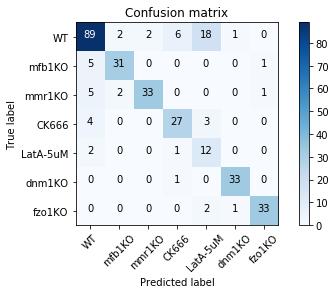

In [49]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

## Test-set eval

### Visualizing train and test datasets as exposed by dataloader

## @Yinan, please take the functionality of the next 2 cells and transfer it to the data_vis.py

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

### Inference

In [50]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

## @James, please transfer the functionality of the next 5 cells into the data_vis.py

In [51]:
# @James, there is definitely a simpler way of generating test_lbl2idx_ than calling this entire line. Please trim it down. 

_, lbl2idx_, test_lbl2idx_ = ImageClassifierData.prepare_from_path(PATH, val_name='val', bs=64, num_workers=1, test_name='test', test_with_labels=True)


In [52]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(test_lbl2idx_.keys()):
    l = h
    h = h + list(data.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

01_WT predictions ready (140 elements)
01_mfb1KO predictions ready (140 elements)
01_mmm1KO predictions ready (195 elements)
01_mmr1KO predictions ready (205 elements)
01_num1KO predictions ready (75 elements)
02_mmr1KO-mfb1KO predictions ready (284 elements)
03_CK666 predictions ready (449 elements)
03_DTT predictions ready (293 elements)
03_Eth predictions ready (295 elements)
03_H2O2 predictions ready (345 elements)
03_LatA-05uM predictions ready (344 elements)
03_axl1KO predictions ready (325 elements)
03_bud1KO predictions ready (290 elements)


In [ ]:
preds_dict['03_bud1KO']

In [54]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data.classes)}
    preds_rel[key]= val

01_WT
01_mfb1KO
01_mmm1KO
01_mmr1KO
01_num1KO
02_mmr1KO-mfb1KO
03_CK666
03_DTT
03_Eth
03_H2O2
03_LatA-05uM
03_axl1KO
03_bud1KO


In [55]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

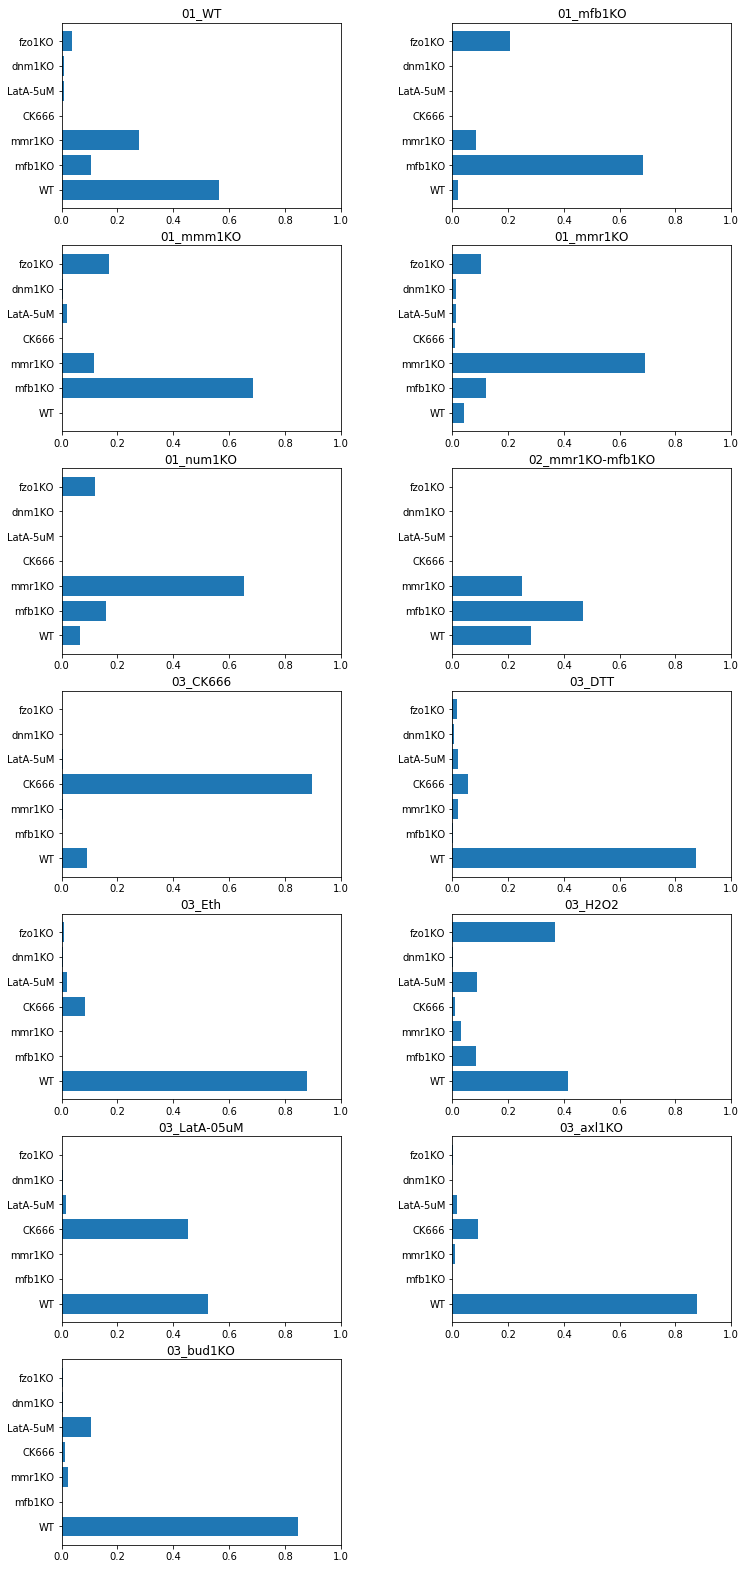

In [56]:
test_classes = list(test_lbl2idx_.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT'], preds_rel)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [151]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [152]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [153]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [154]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [155]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

Correctly classified


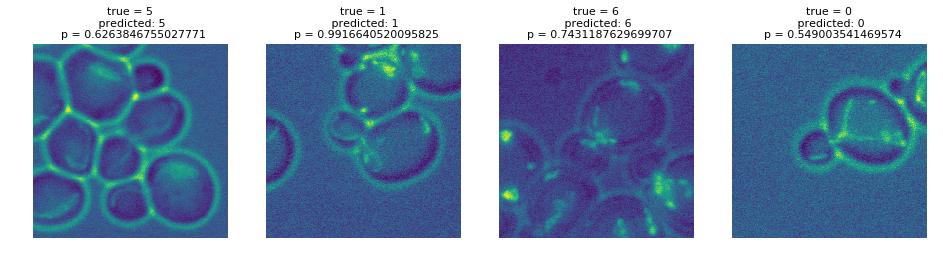

In [156]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

Incorrectly classified


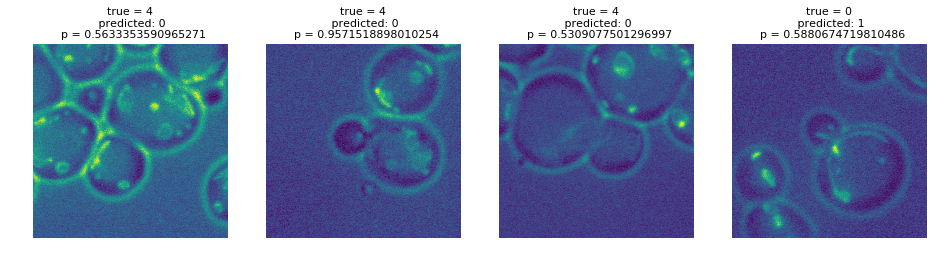

In [157]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [167]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

Most correctly classified WT


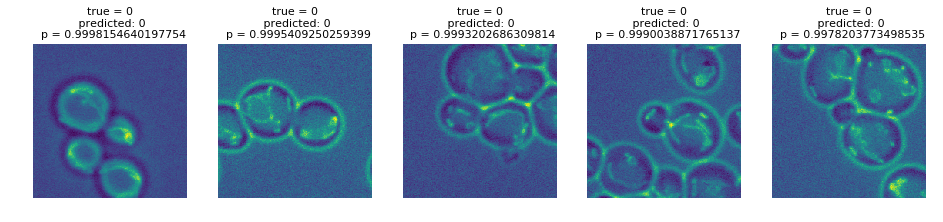

In [168]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

Most incorrectly classified WT


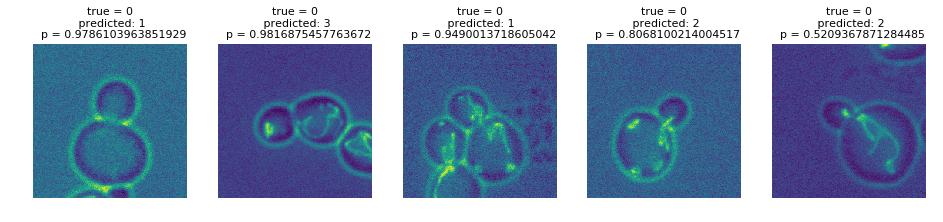

In [169]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

Most correctly classified mfb1KO


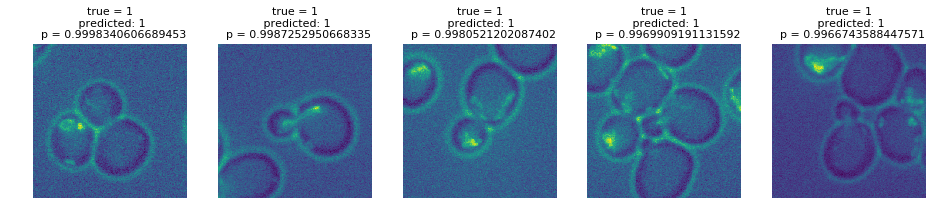

In [170]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

Most incorrectly classified mfb1KO


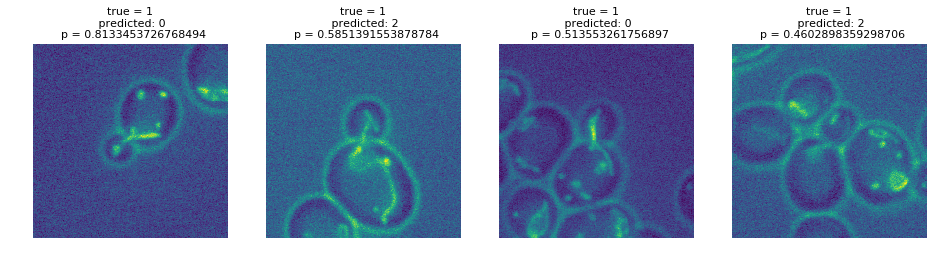

In [171]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

Most correctly classified mfb1KO-mmr1KO


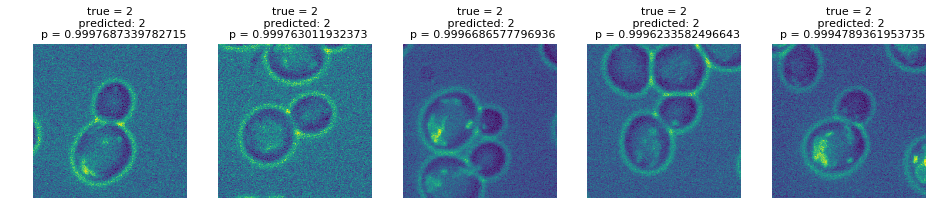

In [172]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

Most correctly classified CK666


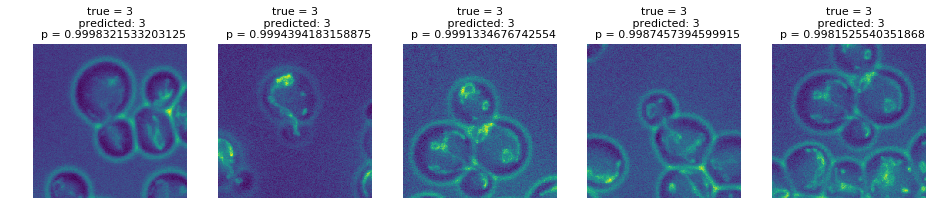

In [180]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

Most correctly classified LatA


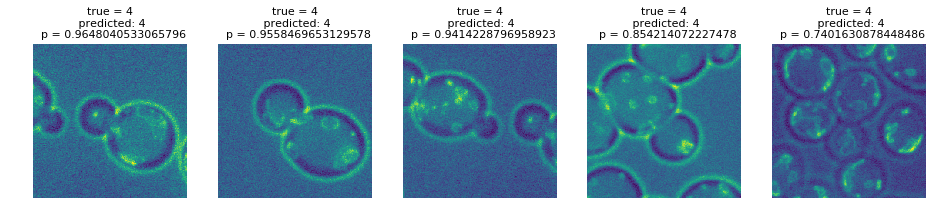

In [179]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

Most correctly classified dnnm1KO


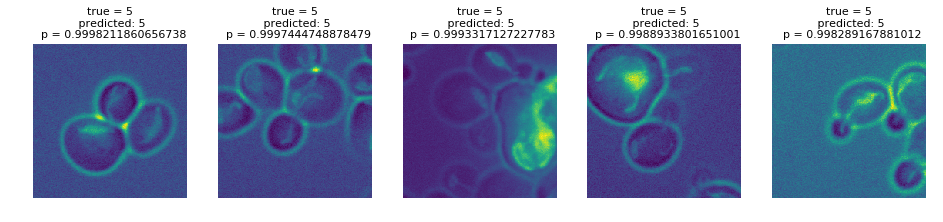

In [182]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

Most correctly classified fzo1KO


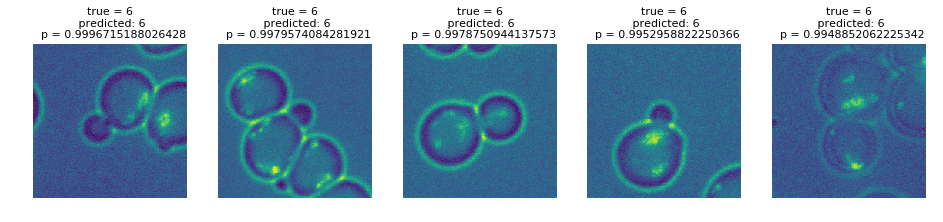

In [184]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

Most uncertain predictions


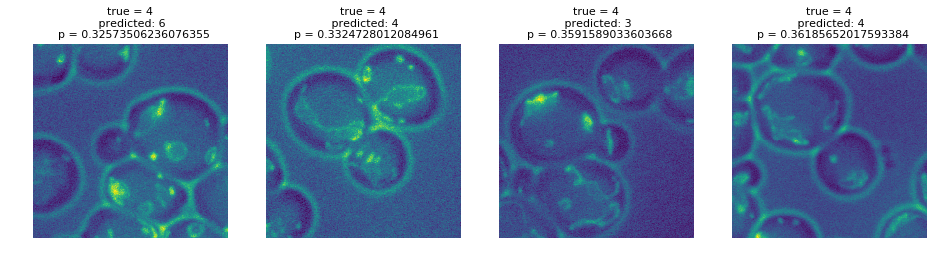

In [176]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [177]:
lbl2idx_

{'02_WT': [0, 0, 'WT'],
 '02_mfb1KO': [1, 1, 'mfb1KO'],
 '02_mmr1KO': [2, 2, 'mmr1KO'],
 '03_CK666': [3, 3, 'CK666'],
 '03_LatA-5uM': [4, 4, 'LatA-5uM'],
 '03_WT': [5, 0, 'WT'],
 '03_dnm1KO': [6, 5, 'dnm1KO'],
 '03_fzo1KO': [7, 6, 'fzo1KO'],
 '04_WT': [8, 0, 'WT']}